In [1]:
from selenium import webdriver as wd
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib import parse
import time
import pandas as pd
import re
from selenium.webdriver.common.keys import Keys
import datetime as dt
import os
import matplotlib.pyplot as plt

In [2]:
def cleanText(readData):
    text = re.sub('[-=+,#/\?:^$.@*\"‚Äª~&%„Üç!„Äè\\‚Äò|\(\)\[\]\<\>`\'‚Ä¶„Äã]', '', readData)
    return text

# ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Î™©Î°ù, ÎßÅÌÅ¨ Ï∂îÏ∂ú

In [3]:
def get_plyst_url():
    search = input()
    url='https://www.youtube.com/results?search_query='+parse.quote(search)+'&sp=EgIQAg%253D%253D'
    result = urlopen(url)
    html = result.read()
    soup = BeautifulSoup(html, 'html.parser')
    k=soup.find('a',{'class':"yt-uix-tile-link yt-ui-ellipsis yt-ui-ellipsis-2 yt-uix-sessionlink spf-link"})
    channel='https://www.youtube.com'+k['href']
    playlist=channel+'/playlists?view=1&flow=grid'
    driver = wd.Chrome(executable_path="chromedriver.exe")
    driver.get(playlist)
    last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(3.0)
        new_page_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_page_height == last_page_height:
            break
        last_page_height = new_page_height
    html2=driver.page_source
    driver.close()
    soup = BeautifulSoup(html2, 'html.parser')
    a=soup.find_all('a',{'class':"yt-simple-endpoint style-scope ytd-grid-playlist-renderer"})
    playlist_link={}
    for i in range(len(a)):
        playlist_link[a[i]['title']]='https://www.youtube.com'+a[i]['href']
    return playlist_link

# ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏Î≥Ñ ÏòÅÏÉÅ ÎßÅÌÅ¨ Ï∂îÏ∂ú(ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Îãπ ÏµúÎåÄ 200Í∞ú) 

In [4]:
def get_video_from_plyst(a):
    url = a
    html = urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    url=soup.find_all('a',{'class':'spf-link playlist-video clearfix yt-uix-sessionlink spf-link'})
    title = soup.find_all('h4',{'class':"yt-ui-ellipsis yt-ui-ellipsis-2"})
    video={'title':[],'link':[]}
    for i in range(len(url)):
        video['title'].append(title[i].text.strip())
        video['link'].append('https://www.youtube.com'+url[i]['href'])    
    return video

# ÎåìÍ∏Ä ÌÅ¨Î°§ÎßÅ

In [136]:
def get_comment(url):
    comment_data = pd.DataFrame({'youtube_id':[],
                                'comment':[],
                                'like_num':[]})
    delay=3

    driver = wd.Chrome(executable_path="chromedriver.exe")#chrome_options=options
    driver.implicitly_wait(delay)

    start_url = url
    driver.get(start_url) 
    
    time.sleep(3)
    body = driver.find_element_by_tag_name('body')
    
    last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
    
    num_page_down = 1
    while num_page_down:
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(1.5)
        num_page_down -= 1
    
    time.sleep(3.0)

    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(3.0)
        new_page_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_page_height == last_page_height:
            break
        last_page_height = new_page_height

    html = driver.page_source
    driver.close()
    html_s = BeautifulSoup(html,'html.parser')

    comment0 = html_s.find_all('ytd-comment-renderer',
                               {'class':'style-scope ytd-comment-thread-renderer'})

    for i in range(len(comment0)):
        #ÎåìÍ∏Ä
        comment = comment0[i].find('yt-formatted-string',
                                   {'id':'content-text','class':'style-scope ytd-comment-renderer'}).text
    
        try:
            aa = comment0[i].find('span',{'id':'vote-count-left'}).text
            #Ï†ïÍ∑úÌëúÌòÑÏãùÏúºÎ°ú Ïà´ÏûêÎßå Ï∂îÏ∂úÌïòÎäî Í≤ÉÏùÄ Ï†ïÍ∑úÌëúÌòÑÏãùÏóê ÎåÄÌïú Í≥µÎ∂ÄÎ•º Îçî Ìïú Îí§ Ìï¥Í≤∞
            #re.findall('[0-9]',aa)
            #"".join(re.findall('[0-9]',aa)) -> Î¶¨Ïä§Ìä∏ ÎÇ¥Î∂ÄÏùò Î¨∏ÏûêÏó¥Ïùò Ìï©
            like_num = "".join(re.findall('[0-9]',aa)) + "Í∞ú"
        except:
            like_num = 0
        
        bb = comment0[i].find('a',{'id':'author-text'}).find('span').text
        youtube_id = "".join(re.findall('[Í∞Ä-Ìû£0-9a-zA-Z]',bb))
    
        insert_data =  pd.DataFrame({'youtube_id':[youtube_id],
                                                   'comment':[comment],
                                                   'like_num':[like_num]})

        comment_data = comment_data.append(insert_data)
    
    comment_data.index = range(len(comment_data))
    return comment_data

# ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ïù¥Î¶ÑÏúºÎ°ú Ìè¥Îçî ÏÉùÏÑ±

In [6]:
a = get_plyst_url()
videos={}

for i in a.keys():
    videos[i] = get_video_from_plyst(a[i])
for i in videos.keys():
    try:
        if not(os.path.isdir(cleanText(i))):
            os.makedirs(os.path.join(cleanText(i)))
    except OSError as e:
        if e.errno != errno.EEXIST:
            print("Failed to create directory!!!!!")
            raise

Ïò§ÌîÑÎ°ú


# ÎèôÏòÅÏÉÅÎ≥Ñ ÎåìÍ∏ÄÏùÑ ÌÅ¨Î°§ÎßÅÌïòÏó¨ ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ìè¥ÎçîÏóê Ï†ÄÏû•

In [138]:
for i in videos.keys():
    for j in range(len(videos[i]['link'])):
        print('Now Crawling: link[{}]'.format(j))
        comment=get_comment(videos[i]['link'][j])
        if len(comment)==0:
            continue
        comment.to_excel('C:\jupyter\\'+cleanText(i)+'\\{}_'.format(j)+cleanText(videos[i]['title'][j])+'.xlsx')

Now Crawling: link[0]
Now Crawling: link[1]
Now Crawling: link[2]
Now Crawling: link[3]
Now Crawling: link[4]
Now Crawling: link[5]
Now Crawling: link[6]
Now Crawling: link[7]
Now Crawling: link[8]
Now Crawling: link[9]
Now Crawling: link[10]
Now Crawling: link[11]
Now Crawling: link[12]
Now Crawling: link[13]
Now Crawling: link[14]
Now Crawling: link[15]
Now Crawling: link[16]
Now Crawling: link[17]
Now Crawling: link[18]
Now Crawling: link[19]
Now Crawling: link[20]
Now Crawling: link[21]
Now Crawling: link[22]
Now Crawling: link[23]
Now Crawling: link[24]
Now Crawling: link[25]
Now Crawling: link[26]
Now Crawling: link[27]
Now Crawling: link[28]
Now Crawling: link[29]
Now Crawling: link[30]
Now Crawling: link[31]
Now Crawling: link[32]
Now Crawling: link[33]
Now Crawling: link[34]
Now Crawling: link[35]
Now Crawling: link[36]
Now Crawling: link[37]
Now Crawling: link[38]
Now Crawling: link[39]
Now Crawling: link[40]
Now Crawling: link[41]
Now Crawling: link[42]
Now Crawling: link[43

# ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏Ïùò ÏòÅÏÉÅ Ï†ïÎ≥¥ Ï∂îÏ∂ú

In [114]:
#ÏûÖÎ†• ÌååÎùºÎØ∏ÌÑ∞Î°ú plyst_videoÏóêÎäî videos['key'] ÎÑ£ÏúºÏãúÎ©¥ Îê©ÎãàÎã§.
def info_from_video(plyst_video):
    title = plyst_video['title']
    link = plyst_video['link']
    thumnail = []
    like = []
    dislike = []
    view = []
    upload_date=[]
    num = len(link)
    while num:
        i = len(link)-num
        print('Now Crawling: link[{}]'.format(i))
        url = link[i]
        html = urlopen(url)
        time.sleep(0.5)
        soup = BeautifulSoup(html, 'html.parser')
        thumnail.append(soup.find('meta',{'name':"twitter:image"})['content'])
        temp = soup.find('button',{'title':'Ïù¥ ÎèôÏòÅÏÉÅÏù¥ ÎßàÏùåÏóê Îì≠ÎãàÎã§.'})
        try:
            temp = temp.text
        except:
            thumnail = thumnail[:(len(thumnail)-1)]
            continue
        like.append(temp)
        temp = soup.find('button',{'title':'Ïù¥ ÎèôÏòÅÏÉÅÏù¥ ÎßàÏùåÏóê Îì§ÏßÄ ÏïäÏäµÎãàÎã§.'})
        temp = temp.text
        dislike.append(temp)
        view.append(soup.find('div',{'class':"watch-view-count"}).text.strip())
        upload_date.append(soup.find('strong',{'class':'watch-time-text'}).text)
        num-=1

    info = {'title':title,'link':link,'thumnails':thumnail,'upload date':upload_date,'like':like,'dislike':dislike,'view':view}
    info_df = pd.DataFrame(info)
    return info_df

In [115]:
for i in videos.keys():
    info=info_from_video(videos[i])
    info.to_excel('C:\jupyter\\'+cleanText(i)+'\\'+cleanText(i)+'_info'+'.xlsx')

Now Crawling: link[0]
Now Crawling: link[1]
Now Crawling: link[2]
Now Crawling: link[3]
Now Crawling: link[4]
Now Crawling: link[5]
Now Crawling: link[6]
Now Crawling: link[7]
Now Crawling: link[8]
Now Crawling: link[9]
Now Crawling: link[9]
Now Crawling: link[10]
Now Crawling: link[11]
Now Crawling: link[12]
Now Crawling: link[13]
Now Crawling: link[14]
Now Crawling: link[15]
Now Crawling: link[16]
Now Crawling: link[17]
Now Crawling: link[18]
Now Crawling: link[19]
Now Crawling: link[20]
Now Crawling: link[20]
Now Crawling: link[21]
Now Crawling: link[22]
Now Crawling: link[23]
Now Crawling: link[24]
Now Crawling: link[25]
Now Crawling: link[26]
Now Crawling: link[27]
Now Crawling: link[28]
Now Crawling: link[29]
Now Crawling: link[30]
Now Crawling: link[31]
Now Crawling: link[32]
Now Crawling: link[33]
Now Crawling: link[34]
Now Crawling: link[35]
Now Crawling: link[36]
Now Crawling: link[37]
Now Crawling: link[38]
Now Crawling: link[39]
Now Crawling: link[40]
Now Crawling: link[41]

# Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÌÅ¨Î°§ÎßÅ ÏΩîÎìú

In [39]:
def uniq(input):
    output = []
    for x in input:
        if x not in output:
            output.append(x)
    return output

# ÌÇ§ÏõåÎìú Í∏∞Î∞ò ÎßÅÌÅ¨ Ï∂îÏ∂ú

In [41]:
def _searchkeyword(keyword):
    url = 'https://www.youtube.com/results?search_query=' + keyword +'+-2020' +'&sp=EgIQAQ%253D%253D'
    driver = wd.Chrome(executable_path="chromedriver.exe")
    driver.get(url)

    time.sleep(5)
    endk = 3

    meta = {'title':[],'link':[]}

    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(3.0)
        html2=driver.page_source
        soup = BeautifulSoup(html2, 'lxml')
        a=soup.find_all('a',{'id':"video-title"})
        for i in a:
            meta['link'].append('https://www.youtube.com'+i['href'])
            meta['title'].append(i['title'])
        meta['link']=uniq(meta['link'])
        meta['title']=uniq(meta['title'])
        if len(meta['link']) > 100:
            break
        
    driver.close()
    return meta

# ÎßÅÌÅ¨ÏóêÏÑú Ï†ïÎ≥¥ Ï∂îÏ∂ú

In [24]:
def _info_from_meta(plyst_video):
    title = plyst_video['title']
    link = plyst_video['link']
    thumnail = []
    like = []
    dislike = []
    view = []
    upload_date=[]
    num = len(link)
    link2 = []
    title2 = []
    thum_err=[]
    like_err=[]
    subscribe=[]
    cnt=0
    while num:
        i = len(link)-num
        print('Now Crawling: link[{}]'.format(i))
        url = link[i]
        name = title[i]
        html = urlopen(url)
        time.sleep(0.5)
        soup = BeautifulSoup(html, 'html.parser')
        try:
            thumnail.append(soup.find('meta',{'name':"twitter:image"})['content'])
        except:
            print('Error: Thumnail Error')
            num-=1
            thum_err.append(i)
            continue
            
        temp = soup.find('button',{'title':'Ïù¥ ÎèôÏòÅÏÉÅÏù¥ ÎßàÏùåÏóê Îì≠ÎãàÎã§.'})
        try:
            temp = temp.text
        except:
            thumnail = thumnail[:(len(thumnail)-1)]
            cnt+=1
            if cnt == 4:
                cnt=0
                num-=1
            continue
        like.append(temp)
        temp = soup.find('button',{'title':'Ïù¥ ÎèôÏòÅÏÉÅÏù¥ ÎßàÏùåÏóê Îì§ÏßÄ ÏïäÏäµÎãàÎã§.'})
        temp = temp.text
        dislike.append(temp)
        view.append(soup.find('div',{'class':"watch-view-count"}).text.strip())
        upload_date.append(soup.find('strong',{'class':'watch-time-text'}).text)
        link2.append(url)
        title2.append(name)
        try:
            subscribe.append(soup.find('span',{'tabindex':'0'}).text.strip())
        except:
            subscribe.append('X')
        num-=1

    info = {'title':title2,'link':link2,'thumnails':thumnail,'upload date':upload_date,'like':like,'dislike':dislike,'view':view
           ,'subscribe':subscribe}
    info_df = pd.DataFrame(info)
    
    #Ïó¨Í∏∞ÏÑúÎ∂ÄÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏΩîÎìú
    for idx, info_df['subscribe']_df['subscribe']):
        if i[-1] == 'Îßå':
            info_df['subscribe'][idx] = float(i[:-1])*10000
        elif i == 'X':
            info_df['subscribe'][idx] = -1
        elif i[-1] == 'Ï≤ú':
            info_df['subscribe'][idx] = float(i[:-1])*1000
        else:
            i = float(i)
            
    info_df['upload date'] = ['-'.join(re.findall('\d+',re.sub('[„Ñ±-Ìû£\: ]','',j))) for j in info_df['upload date']]
    info_df['like'] = [int(re.sub(',','',i)) for i in info_df['like']]
    info_df['dislike'] = [int(re.sub(',','',i)) for i in info_df['dislike']]
    info_df['view'] = [int(re.sub('[„Ñ±-Ìû£\,]','',i)) for i in info_df['view']]
    
    info_df = info_df[info_df['subscribe']!=-1][info_df['like']!='' ]
    
    info_df['like_ratio'] = round(info_df['like'] / (info_df['like'] + info_df['dislike']),5)
    info_df['view_subscribe'] = round(info_df['view']/ info_df['subscribe'],5)
    info_df['like_subscribe'] = round(info_df['like']/ info_df['subscribe'],5)
    info_df['like_view'] = round(info_df['like']/ info_df['view'],5)
    
    return info_df

# ÌÅ¨Î°§ÎßÅ ÏûêÎèôÌôî Ìï®Ïàò

In [2]:
#Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÌÅ¨Î°§ÎßÅ
def crawling_meta_data():
    keyword=[]
    print('If you want to enter keywords, please enter \'n\'')
    while 1:
        k=input('Please Enter the contents Keyword: ')
        if k == 'n':
            break
        else: keyword.append(k)
    
    #Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Î•º Ï†ÄÏû•Ìï† ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
    try:
        if not(os.path.isdir('meta_data')):
            os.makedirs(os.path.join('meta_data'))
    except OSError as e:
        if e.errno != errno.EEXIST:
            print("Failed to create directory!!!!!")
            raise
    
    df={}
    meta={}
        
    for i in keyword:
        meta[i] = _searchkeyword(i)
        df[i]=_info_from_meta(meta[i])
        df[i].to_csv('.\\meta_data\\{}.txt'.format(i))
    
    return df

## ÌïÑÏöî Îç∞Ïù¥ÌÑ∞
### 1. nadrop.txt ÌååÏùº
### 2. Ïò§ÌîÑÎ°ú Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Ìè¥ÎçîÌååÏùº

In [1]:
from selenium import webdriver as wd
from selenium.webdriver.common.keys import Keys
from time import localtime, strftime
from urllib.request import urlopen
from urllib import parse
import time
from bs4 import BeautifulSoup
import pandas as pd
import csv
import re
import pandas as pd
import re

In [2]:
keyword = ['ÏãùÎãπÌõÑÍ∏∞','ÏßÅÏóÖ','Î∏åÏù¥Î°úÍ∑∏','ÌÜ†ÌÅ¨','Ï†úÌíàÎ¶¨Î∑∞']
categories =  ['‚ô£Food  Restaurant Review', '‚ô£JOBÏÜåÎ¶¨ Talk', '‚ô£Vlog lÏó¨Ìñâ', 
               '‚ô£Ïò§ÌîÑÎ°ú Talk', '‚ô£Ï†úÌíà Î¶¨Î∑∞ l Product Review']

In [3]:
meta_data={}
#ÏàòÏ†ïÎêú ÏΩîÎìúÎäî .txtÎ°ú Î∞îÎ°ú Î∂àÎü¨ÏôÄÎèÑ ÎêòÏßÄÎßå Ï†ÄÌù¨Îäî _meta_2.txtÎ°ú Î∂àÎü¨ÏôÄÏïºÌï©ÎãàÎã§.
for i in keyword:
    meta_data[i] = pd.read_csv(i+'nadrop.txt').dropna(axis=0)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.stats import poisson as poi
import os

In [5]:
import math as m

In [6]:
import re
import matplotlib.font_manager as fm

In [10]:
for i in keyword:
    meta_data[i] = meta_data[i][meta_data[i]['subscribe']!=-1][meta_data[i]['like']!=999999 ]
    meta_data[i] = meta_data[i][meta_data[i]['subscribe'] > 0]
    meta_data[i] = meta_data[i][meta_data[i]['like'] > 1]

In [13]:
def getresults(key):
    fontprop = fm.FontProperties(fname="NanumGothicBold.ttf", size=24)
    
    path = "Ïò§ÌîÑÎ°ú//"+categories[key]
    file_list = os.listdir(path)
    file_path = path + "//"+file_list[-1]
    org_df = pd.read_excel(file_path)
    org_df['subscribe'] = float(19200)
    
    # Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
    org_df['upload date'] = ['-'.join(re.findall('\d+',re.sub('[„Ñ±-Ìû£\: ]','',j))) for j in org_df['upload date']]
    org_df['like'] = [float(re.sub(',','',str(i))) for i in org_df['like']]
    org_df['dislike'] = [float(re.sub(',','',str(i))) for i in org_df['dislike']]
    org_df['view'] = [int(re.sub('[„Ñ±-Ìû£\,]','',i)) for i in org_df['view']]
    
    # ÏßÄÌëú ÏÉùÏÑ±
    org_df = org_df[['title','upload date', 'like', 'dislike','view','subscribe' ]]
    org_df['like_ratio'] = round(org_df['like'] / (org_df['like'] + org_df['dislike']),5)
    org_df['view_subscribe'] = round(org_df['view']/ org_df['subscribe'],5)
    org_df['like_subscribe'] = round(org_df['like']/ org_df['subscribe'],5)
    org_df['like_view'] = round(org_df['like']/ org_df['view'],5)
    
    #Í≤∞Ï∏°Ïπò Ï†úÍ±∞
    org_df=org_df.dropna(axis=0)

    # ÏßÄÌëúÎ≥Ñ ÌèâÍ∑† Íµ¨ÌïòÍ∏∞
    like_ratio = org_df['like_ratio'].mean()
    view_subscribe = org_df['view_subscribe'].mean()
    like_view = org_df['like_view'].mean()
    like_subscribe = org_df['like_subscribe'].mean()
    i = keyword[key]
    
    f = plt.figure(figsize=(10,10))
    fig1 = f.add_subplot(221)
    fig2 = f.add_subplot(222)
    fig3 = f.add_subplot(223)
    fig4 = f.add_subplot(224)

    
    print(i,"Ïû•Î•¥ ÎÇ¥ Í≤∞Í≥ºÏûÖÎãàÎã§.")
    # like_view
    
    lamb1=sum(meta_data[i]['like_view'])*1000/len(meta_data[i]['like_view'])
    max1 = max(meta_data[i]['like_view']*1000)
    min1 = min(meta_data[i]['like_view']*1000)
    x1=np.linspace(min1,max1,100)
    y1=poi(lamb1).pmf(x1)
        
    fig1.set_title('1000Ï°∞ÌöåÏàò Îãπ Ï¢ãÏïÑÏöî',fontproperties=fontprop,fontsize=10)
    fig1.set_ylabel('ÌôïÎ•†',fontproperties=fontprop,fontsize=10)
    fig1.plot(x1,y1)
        
    mu=np.arange(0,round((like_view*1000),0)+1,1)
    mu_y=poi(lamb1).pmf(mu)
    tier = round((1-sum(mu_y))*100,2)
    
    fig1.plot(mu,mu_y,'r')
    fig1.fill_between(mu,mu_y,facecolor='r')
    
    fig1.set_xlabel('Ï°∞ÌöåÏàò ÎåÄÎπÑ Ï¢ãÏïÑÏöî ÎπÑÏú®ÏùÄ ÏÉÅÏúÑ {}%ÏûÖÎãàÎã§'.format(tier),fontproperties=fontprop,fontsize=12)

    
    
    # like_subscribe
    logged = np.log(meta_data[i][meta_data[i]['like_subscribe']<200]['like_subscribe'])
    m = logged.describe()['mean']
    std = logged.describe()['std']
    rv = st.norm(loc = m, scale = std)
    max2=max(logged)
    min2=min(logged)
    x2=np.linspace(min2,max2,100)
    y2=rv.pdf(x2)
    fig2.plot(x2,y2)
    mu2=np.linspace(min2,np.log(like_subscribe),100)
    mu2_y=rv.pdf(mu2)
    fig2.plot(mu2,mu2_y,'r')
    fig2.fill_between(mu2,mu2_y,facecolor='r')
    tik=np.linspace(min2,max2,5)
    fig2.set_xticks(tik)
    fig2.set_xticklabels([round(i,2)for i in np.exp(tik)]) 
    
    tier = round(100-rv.cdf(np.log(like_subscribe))*100,2)
    fig2.set_xlabel('Íµ¨ÎèÖÏûê ÎåÄÎπÑ Ï¢ãÏïÑÏöî ÏÉÅÏúÑ {}%ÏûÖÎãàÎã§'.format(tier),fontproperties=fontprop,fontsize=12)
    fig2.set_ylabel('ÌôïÎ•†',fontproperties=fontprop,fontsize=10)
    fig2.set_title('Ï¢ãÏïÑÏöî/Íµ¨ÎèÖÏûê',fontproperties=fontprop,fontsize=10)
    
    
    # like_ratio
    logged = np.log(meta_data[i]['like_ratio'])
    m = logged.describe()['mean']
    std = logged.describe()['std']
    a, loc, scale = st.skewnorm.fit(logged)
    rv = st.skewnorm(a = a, loc = loc, scale = scale)
    max3=max(logged)
    min3=min(logged)
    x3=np.linspace(min3,max3,100)
    y3=rv.pdf(x3)
    fig3.plot(x3,y3)
    mu3=np.linspace(min3,np.log(like_ratio),100)
    mu3_y=rv.pdf(mu3)
    fig3.plot(mu3,mu3_y,'r')
    fig3.fill_between(mu3,mu3_y,facecolor='r')
    tier = round(100-rv.cdf(np.log(like_ratio))*100,2)
    tik=np.linspace(min3,max3,5)
    fig3.set_xticks(tik)
    fig3.set_xticklabels([round(i,2)for i in np.exp(tik)])
    fig3.set_xlabel('Ï¢ãÏïÑÏöî ÎπÑÏú®ÏùÄ ÏÉÅÏúÑ {}%ÏûÖÎãàÎã§'.format(tier),fontproperties=fontprop,fontsize=12)
    fig3.set_ylabel('ÌôïÎ•†',fontproperties=fontprop,fontsize=10)
    fig3.set_title('Ï¢ãÏïÑÏöî/Ï¢ãÏïÑÏöî+Ïã´Ïñ¥Ïöî',fontproperties=fontprop,fontsize=10)
    
    # view_subscribe
    logged = np.log(meta_data[i]['view_subscribe'])
    m = logged.describe()['mean']
    std = logged.describe()['std']
    rv = st.norm(loc = m, scale = std)
    max4=max(logged)
    min4=min(logged)
    x4=np.linspace(min4,max4,100)
    y4=rv.pdf(x4)
    fig4.plot(x4,y4)
    mu4=np.linspace(min4,np.log(view_subscribe),100)
    mu4_y=rv.pdf(mu4)
    fig4.plot(mu4,mu4_y,'r')
    fig4.fill_between(mu4,mu4_y,facecolor='r')
    tier = round(100-rv.cdf(np.log(view_subscribe))*100,2)
    tik=np.linspace(min4,max4,5)
    fig4.set_xticks(tik)
    fig4.set_xticklabels([round(i,2)for i in np.exp(tik)])
    fig4.set_xlabel('Íµ¨ÎèÖÏûê ÎåÄÎπÑ Ï°∞ÌöåÏàò ÎπÑÏú®ÏùÄ ÏÉÅÏúÑ {}%ÏûÖÎãàÎã§'.format(tier),fontproperties=fontprop,fontsize=12)
    fig4.set_ylabel('ÌôïÎ•†',fontproperties=fontprop,fontsize=10)
    fig4.set_title('Ï°∞ÌöåÏàò/Íµ¨ÎèÖÏûê',fontproperties=fontprop,fontsize=10)
    plt.show()
    f.savefig(i+'.png',dpi=f.dpi)

ÏãùÎãπÌõÑÍ∏∞ Ïû•Î•¥ ÎÇ¥ Í≤∞Í≥ºÏûÖÎãàÎã§.


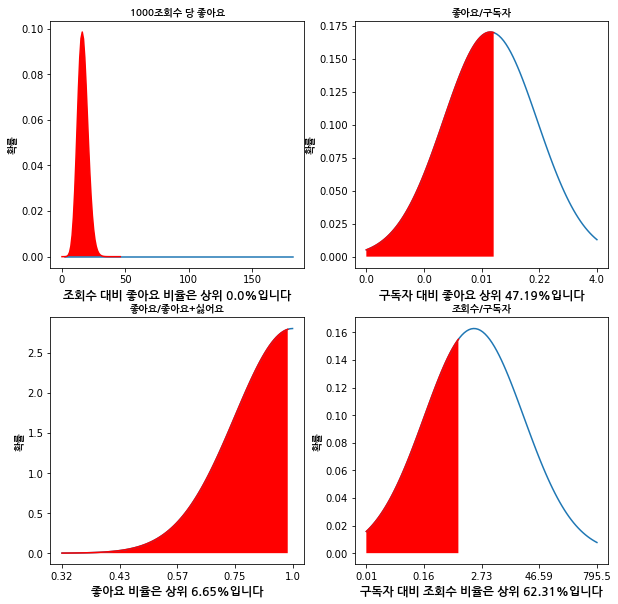



ÏßÅÏóÖ Ïû•Î•¥ ÎÇ¥ Í≤∞Í≥ºÏûÖÎãàÎã§.


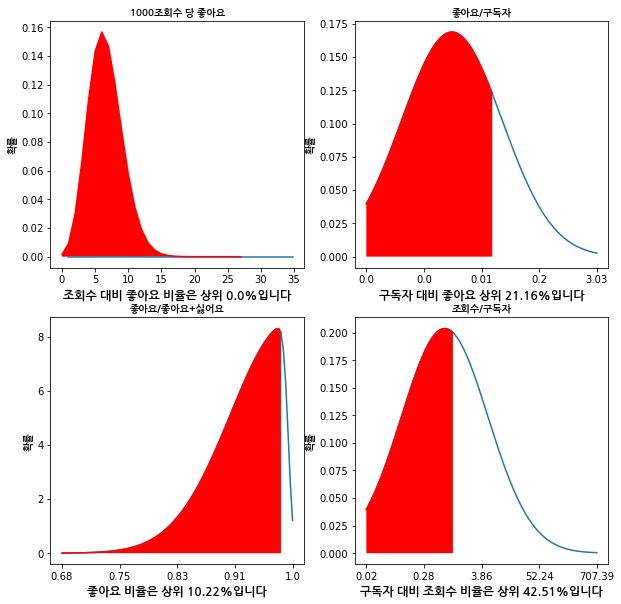



Î∏åÏù¥Î°úÍ∑∏ Ïû•Î•¥ ÎÇ¥ Í≤∞Í≥ºÏûÖÎãàÎã§.


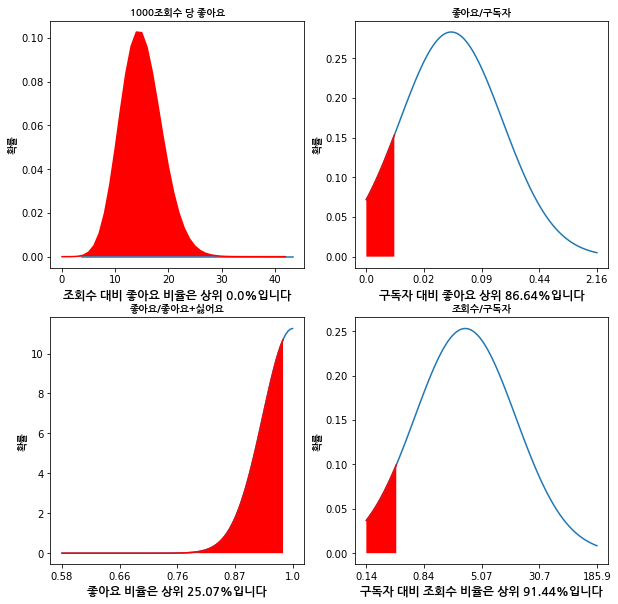



ÌÜ†ÌÅ¨ Ïû•Î•¥ ÎÇ¥ Í≤∞Í≥ºÏûÖÎãàÎã§.


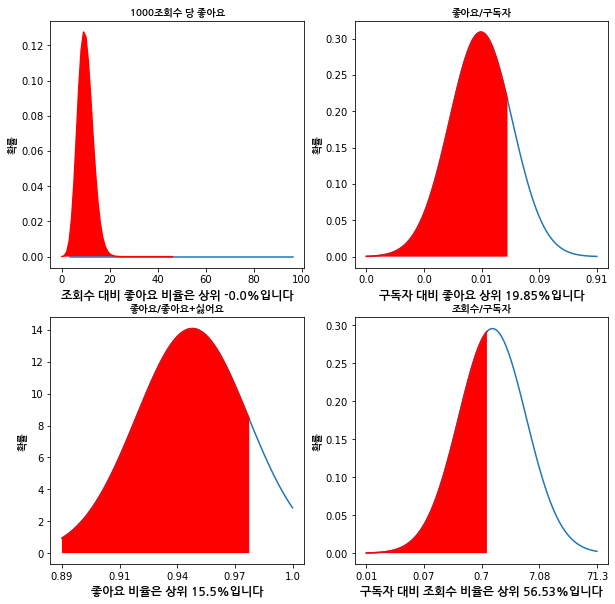



Ï†úÌíàÎ¶¨Î∑∞ Ïû•Î•¥ ÎÇ¥ Í≤∞Í≥ºÏûÖÎãàÎã§.


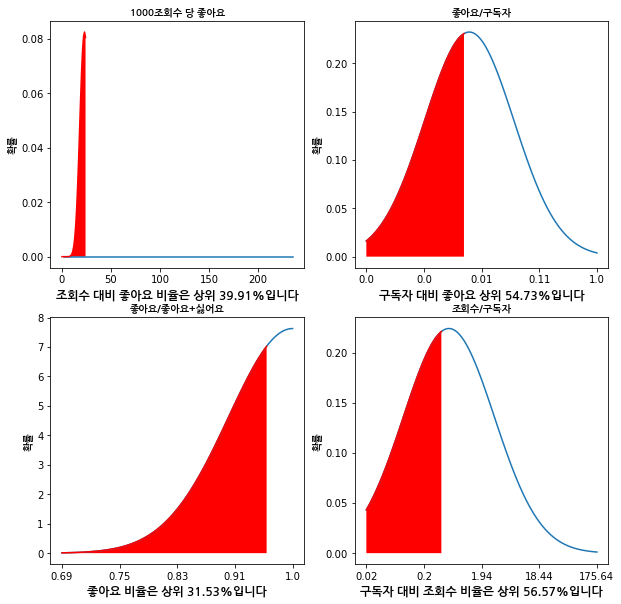

In [14]:
for i in range(len(keyword)):
    getresults(i)
    print('\n')

# Sentiment Ï†ÅÏö©

## Vlog

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,24):
    dfname = "Vlog" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)

In [4]:
df=pd.concat(df)

In [5]:
df.head()

Unnamed: 0 youtube_id                                            comment  \
0           0   Ïò§ÌîÑÎ°úOhPro  (‚òÖÏó¨Îü¨Î∂Ñ ÏòÅÏÉÅ Ï§ëÏóê Ï†úÍ∞Ä Í∑ºÎåÄÎ•º ÏÉêÎü¨ÎìúÏóê Ìè¨Ìï®Ìï¥ÏÑú Î®πÎäî Ïû•Î©¥Ïù¥ ÎÇòÏò§ÎäîÎç∞ Í∑ºÎåÄÎäî ÏÉù...   
1           1         Ïû¨Ìö¨  Í≥†ÎØºÏùÑ Îì§Ïñ¥Ï£ºÏÑ∏Ïöî\nÏïàÎÖïÌïòÏÑ∏Ïöî\nÏ†Ñ ÌïôÏÉùÏûÖÎãàÎã§\nÏ†Ñ ÌïôÏõêÏóêÏÑú Ï†ú ÏûòÎ™ªÎïúÏóê ÏÇ¨Ïù¥Í∞Ä ÌãÄ...   
2           2  GraceJeon  Î∞îÎ•∏ÏÉùÌôúÏò§ÌîÑÎ°úÎãò!\nÏò§ÌîÑÎ°úÎãòÏùò Ïû°ÏÜåÎ¶¨Ïóê Í≥µÍ∞ê ÎßéÏù¥ ÌïòÎã§Í∞Ä Íµ¨ÎèÖÏûêÍ∞Ä ÎêòÏóàÎäîÎç∞...\n...   
3           3         Î≥¥ÎÇò  Î∞ïÏä§Ïïà Íµ¨ÎèÖÏ¢ÖÏù¥ Ï†ïÎßê ÌòºÏûê ÎπµÌÑ∞Ï†∏ ÏõÉÏóàÎÑ§Ïöî ü§≠ü§≠ü§≠ü§≠\nÏùºÏÉÅ Î∏åÏù¥Î°úÍ∑∏ ÏòÅÏÉÅ ÎÑò Ï¢ãÏïÑÏöîü§óü§≠üëç   
4           4        MmM                           ÏôÄ...ÏûêÏ∑®ÌïòÎ©¥ÏÑú Î≠îÍ∞ÄÎ•º Ìï¥Î®πÎäîÎã§ÎäîÍ≤å ÎåÄÎã®üëç   

  like_num  
0      10Í∞ú  
1       3Í∞ú  
2       2Í∞ú  
3       3Í∞ú  
4       3Í∞ú

In [6]:
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='Í∞àÎì±'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [13]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

k_t=pd.DataFrame(k)

pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

k_f=k_t.T

k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])df.reset_index(drop=True, inplace=True) #Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î¶¨Ïù∏Îç±Ïã±

In [14]:
#ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^Í∞Ä-Ìû£0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [19]:
k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

In [20]:
for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

In [21]:
k_t=pd.DataFrame(k)

In [22]:
pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

In [23]:
k_f=k_t.T

In [24]:
k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

In [25]:
k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])

C:\Users\4770pc2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
k_f['SO_MI']=k_f['MI_P'] - k_f['MI_N']

In [27]:
k_n=k_f.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [28]:
k_n.sort_values(by=['SO_MI'],ascending=False)

W1  W1W2P  W1W2N  neg_cnt  pos_cnt        N       MI_N       MI_P  \
Îã§ÎÇ≠    4698   2592    162    27540   121986  3644676  31.688619  37.835734   
Î≥∏     2916   2430    162    27540   121986  3644676  32.376675  38.430681   
Ïû¨Î∞åÍ≤å   2754   2106    162    27540   121986  3644676  32.459137  38.306692   
Ïó∞Îßê    1944   1620    162    27540   121986  3644676  32.961638  38.430681   
Ïù¥ÏóêÏöî   2430   1620    162    27540   121986  3644676  32.639709  38.108753   
...    ...    ...    ...      ...      ...      ...        ...        ...   
ÏßÅÏû•     648    162    324    27540   121986  3644676  35.546600  36.693715   
Ïù¥ÏÉÅÌïòÍ≤å   486    162    486    27540   121986  3644676  36.546600  37.108753   
ÌõÑÌöå     486    162    486    27540   121986  3644676  36.546600  37.108753   
Ìåå      648    162    486    27540   121986  3644676  36.131563  36.693715   
Î≤å      648    162    648    27540   121986  3644676  36.546600  36.693715   

         SO_MI  
Îã§ÎÇ≠    6.147115  
Î≥∏     6.054006  
Ïû¨Î∞åÍ≤å   5.847555  
Ïó∞Îßê    5.469043  
Ïù¥ÏóêÏöî   5.469043  
...        ...  
ÏßÅÏû•    1.147115  
Ïù¥ÏÉÅÌïòÍ≤å  0.562153  
ÌõÑÌöå    0.562153  
Ìåå     0.562153  
Î≤å     0.147115  

[2272 rows x 9 columns]

In [29]:
add_Dic = {0:[],1:[]}
for i in k_n[k_n['SO_MI']>0].T.keys():
    if i not in list(sent_dic[0]):
        if len(i) > 1:
            add_Dic[0].append(i)
            add_Dic[1].append(1.0)
for i in k_n[k_n['SO_MI']<0].T.keys():
    if i not in list(sent_dic[0]):
        add_Dic[0].append(i)
        add_Dic[1].append(-1.0)

In [30]:
add_Dic=pd.DataFrame(add_Dic)

In [31]:
Sentiment=pd.merge(sent_dic,add_Dic,'outer')

In [32]:
cnt = []
for i in df_s['comment']:
    count=0
    for j in list(set(i)):
        if len(Sentiment[Sentiment[0]==j])==1:
            a = float(Sentiment[Sentiment[0]==j][1])
            count += a
    cnt.append(count)

In [33]:
df['score']=cnt

In [34]:
ratio=[]
for i in range(len(df['score'])):
    ratio.append(round(df['score'][i]/len(df_s['comment'][i]),2))

C:\Users\4770pc2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df['cm_ratio']=ratio
df=df.fillna(0)

In [36]:
df.to_excel('sentiment_total_score_vlog.xlsx')

In [37]:
ts=pd.read_excel('sentiment_total_score_vlog.xlsx')

In [38]:
ts.head()

Unnamed: 0  Unnamed: 0.1 youtube_id  \
0           0             0   Ïò§ÌîÑÎ°úOhPro   
1           1             1         Ïû¨Ìö¨   
2           2             2  GraceJeon   
3           3             3         Î≥¥ÎÇò   
4           4             4        MmM   

                                             comment  like_num  score  \
0  (‚òÖÏó¨Îü¨Î∂Ñ ÏòÅÏÉÅ Ï§ëÏóê Ï†úÍ∞Ä Í∑ºÎåÄÎ•º ÏÉêÎü¨ÎìúÏóê Ìè¨Ìï®Ìï¥ÏÑú Î®πÎäî Ïû•Î©¥Ïù¥ ÎÇòÏò§ÎäîÎç∞ Í∑ºÎåÄÎäî ÏÉù...        10     33   
1  Í≥†ÎØºÏùÑ Îì§Ïñ¥Ï£ºÏÑ∏Ïöî\nÏïàÎÖïÌïòÏÑ∏Ïöî\nÏ†Ñ ÌïôÏÉùÏûÖÎãàÎã§\nÏ†Ñ ÌïôÏõêÏóêÏÑú Ï†ú ÏûòÎ™ªÎïúÏóê ÏÇ¨Ïù¥Í∞Ä ÌãÄ...         3     43   
2  Î∞îÎ•∏ÏÉùÌôúÏò§ÌîÑÎ°úÎãò!\nÏò§ÌîÑÎ°úÎãòÏùò Ïû°ÏÜåÎ¶¨Ïóê Í≥µÍ∞ê ÎßéÏù¥ ÌïòÎã§Í∞Ä Íµ¨ÎèÖÏûêÍ∞Ä ÎêòÏóàÎäîÎç∞...\n...         2     40   
3  Î∞ïÏä§Ïïà Íµ¨ÎèÖÏ¢ÖÏù¥ Ï†ïÎßê ÌòºÏûê ÎπµÌÑ∞Ï†∏ ÏõÉÏóàÎÑ§Ïöî ü§≠ü§≠ü§≠ü§≠\nÏùºÏÉÅ Î∏åÏù¥Î°úÍ∑∏ ÏòÅÏÉÅ ÎÑò Ï¢ãÏïÑÏöîü§óü§≠üëç         3      8   
4                           ÏôÄ...ÏûêÏ∑®ÌïòÎ©¥ÏÑú Î≠îÍ∞ÄÎ•º Ìï¥Î®πÎäîÎã§ÎäîÍ≤å ÎåÄÎã®üëç         3      4   

   cm_ratio  
0      0.36  
1      0.33  
2      0.60  
3      0.57  
4      0.50

In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [41]:
ts.head()

Unnamed: 0  Unnamed: 0.1 youtube_id  \
0           0             0   Ïò§ÌîÑÎ°úOhPro   
1           1             1         Ïû¨Ìö¨   
2           2             2  GraceJeon   
3           3             3         Î≥¥ÎÇò   
4           4             4        MmM   

                                             comment  like_num  score  \
0  (‚òÖÏó¨Îü¨Î∂Ñ ÏòÅÏÉÅ Ï§ëÏóê Ï†úÍ∞Ä Í∑ºÎåÄÎ•º ÏÉêÎü¨ÎìúÏóê Ìè¨Ìï®Ìï¥ÏÑú Î®πÎäî Ïû•Î©¥Ïù¥ ÎÇòÏò§ÎäîÎç∞ Í∑ºÎåÄÎäî ÏÉù...        10     33   
1  Í≥†ÎØºÏùÑ Îì§Ïñ¥Ï£ºÏÑ∏Ïöî\nÏïàÎÖïÌïòÏÑ∏Ïöî\nÏ†Ñ ÌïôÏÉùÏûÖÎãàÎã§\nÏ†Ñ ÌïôÏõêÏóêÏÑú Ï†ú ÏûòÎ™ªÎïúÏóê ÏÇ¨Ïù¥Í∞Ä ÌãÄ...         3     43   
2  Î∞îÎ•∏ÏÉùÌôúÏò§ÌîÑÎ°úÎãò!\nÏò§ÌîÑÎ°úÎãòÏùò Ïû°ÏÜåÎ¶¨Ïóê Í≥µÍ∞ê ÎßéÏù¥ ÌïòÎã§Í∞Ä Íµ¨ÎèÖÏûêÍ∞Ä ÎêòÏóàÎäîÎç∞...\n...         2     40   
3  Î∞ïÏä§Ïïà Íµ¨ÎèÖÏ¢ÖÏù¥ Ï†ïÎßê ÌòºÏûê ÎπµÌÑ∞Ï†∏ ÏõÉÏóàÎÑ§Ïöî ü§≠ü§≠ü§≠ü§≠\nÏùºÏÉÅ Î∏åÏù¥Î°úÍ∑∏ ÏòÅÏÉÅ ÎÑò Ï¢ãÏïÑÏöîü§óü§≠üëç         3      8   
4                           ÏôÄ...ÏûêÏ∑®ÌïòÎ©¥ÏÑú Î≠îÍ∞ÄÎ•º Ìï¥Î®πÎäîÎã§ÎäîÍ≤å ÎåÄÎã®üëç         3      4   

   cm_ratio  like_score  
0      0.36         330  
1      0.33         129  
2      0.60          80  
3      0.57          24  
4      0.50          12

In [43]:
sent=sum(ts['like_score'])/len(ts)

In [54]:
f=open("Ïò§ÌîÑÎ°ú_Ïª®ÏÑ§ÌåÖ.txt", 'a')
print("VlogÏùò Í∞êÏÑ±Ï†êÏàòÎäî",sent,"Ï†êÏûÖÎãàÎã§","\n",file=f)
f.close()

## Talk

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,70):
    dfname = "talk" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)

In [4]:
df=pd.concat(df)
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='Í∞àÎì±'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [13]:
df.reset_index(drop=True, inplace=True) #Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î¶¨Ïù∏Îç±Ïã±

In [14]:
#ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^Í∞Ä-Ìû£0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [19]:
k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

In [20]:
for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

In [21]:
k_t=pd.DataFrame(k)

In [22]:
pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

In [23]:
k_f=k_t.T

In [24]:
k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

In [25]:
k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])

C:\Users\4770pc2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
k_f['SO_MI']=k_f['MI_P'] - k_f['MI_N']

In [27]:
k_n=k_f.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [28]:
k_n.sort_values(by=['SO_MI'],ascending=False)

W1  W1W2P  W1W2N  neg_cnt  pos_cnt         N       MI_N       MI_P  \
Ï£ºÌñâ    5696   5696    356   713780  1605916  51577280  41.065352  46.235197   
Ï≤ú     3916   3560    356   713780  1605916  51577280  41.605921  46.097694   
Ïù¥Ïã≠    3560   3560    356   713780  1605916  51577280  41.743424  46.235197   
Í≥†ÎßàÏõåÏöî  5696   3560    356   713780  1605916  51577280  41.065352  45.557125   
Ìï¥Î≥¥Í≥†   7476   6408    712   713780  1605916  51577280  41.673035  46.012805   
...    ...    ...    ...      ...      ...       ...        ...        ...   
Ï§ëÎèÖ    3204    712   3204   713780  1605916  51577280  45.065352  44.065272   
Ï≤†     1780    356   1780   713780  1605916  51577280  45.065352  43.913269   
ÏΩîÏù∏    2492    356   1780   713780  1605916  51577280  44.579925  43.427842   
Îú®Í∏∞    2136    356   2136   713780  1605916  51577280  45.065352  43.650235   
Ïä§Ìè¨    2848    356   2848   713780  1605916  51577280  45.065352  43.235197   

         SO_MI  
Ï£ºÌñâ    5.169845  
Ï≤ú     4.491773  
Ïù¥Ïã≠    4.491773  
Í≥†ÎßàÏõåÏöî  4.491773  
Ìï¥Î≥¥Í≥†   4.339770  
...        ...  
Ï§ëÎèÖ   -1.000080  
Ï≤†    -1.152083  
ÏΩîÏù∏   -1.152083  
Îú®Í∏∞   -1.415117  
Ïä§Ìè¨   -1.830155  

[10968 rows x 9 columns]

In [29]:
add_Dic = {0:[],1:[]}
for i in k_n[k_n['SO_MI']>0].T.keys():
    if i not in list(sent_dic[0]):
        if len(i) > 1:
            add_Dic[0].append(i)
            add_Dic[1].append(1.0)
for i in k_n[k_n['SO_MI']<0].T.keys():
    if i not in list(sent_dic[0]):
        add_Dic[0].append(i)
        add_Dic[1].append(-1.0)

In [30]:
add_Dic=pd.DataFrame(add_Dic)

In [31]:
Sentiment=pd.merge(sent_dic,add_Dic,'outer')

In [32]:
cnt = []
for i in df_s['comment']:
    count=0
    for j in list(set(i)):
        if len(Sentiment[Sentiment[0]==j])==1:
            a = float(Sentiment[Sentiment[0]==j][1])
            count += a
    cnt.append(count)

In [33]:
df['score']=cnt

In [34]:
ratio=[]
for i in range(len(df['score'])):
    ratio.append(round(df['score'][i]/len(df_s['comment'][i]),2))

C:\Users\4770pc2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df['cm_ratio']=ratio
df=df.fillna(0)

In [36]:
df.to_excel('sentiment_total_score_talk.xlsx')

In [37]:
ts=pd.read_excel('sentiment_total_score_talk.xlsx')

In [38]:
ts.head()

Unnamed: 0  Unnamed: 0.1 youtube_id  \
0           0             0   Ïò§ÌîÑÎ°úOhPro   
1           1             1        ÏßÄÌõàÏú†   
2           2             2        ÏãúÌòÑÏÜ°   
3           3             3        ÏïàÏòÅÏù¥   
4           4             4        Ï†ïÏãúÏó∞   

                                             comment  like_num  score  \
0  Ïó¨Îü¨Î∂Ñ~~ÏóÖÎ°úÎìúÍ∞Ä ÎÑàÎ¨¥ Îä¶ÏóàÏ£†!? Ïù¥Î≤à Ï£ºÏóê ÏùºÎì§Ïù¥ Ï¢Ä Í≤πÏ≥êÏÑú Îä¶ÏóàÏñ¥Ïöî ÌùëÌùë.. 6...        13     43   
1  Ï†ÄÎèÑ Ï†úÏùº ÏÉÅÏ≤ò Î∞õÎäî ÎßêÏùÑ Î∞õÏïòÏùÑ ÎïåÎäî ÌôîÍ∞Ä ÎßéÏù¥ ÎÇòÏ£†. ÎàÑÎÇòÏ≤òÎüº Ï†ÄÎèÑ ÏÑ†Ìïú Î∞©Ìñ•Ïúº...         4      7   
2                  ÌòÑÎ™ÖÌïòÍ≥† ÏßÄÌòúÎ°úÏö¥ Í∑∏ÎÖÄ . ÎèôÏÉùÏù¥ÏßÄÎßå Ïñ∏ÎãàÎùºÍ≥† Î∂ÄÎ•¥Í≥† Ïã∂Îã§‚ô°         3      9   
3  ÏÉÅÏ≤òÎäî Ïù∏Ï†ïÏöïÍµ¨ÎïåÎ¨∏Ïóê Îçî ÏÉùÍ∏∞Îäî Í±∞ Í∞ôÏïÑÏöî.\n\nÍ∏∞ÎåÄÍ∞Ä ÌÅ¨Î©¥ Ïã§ÎßùÏù¥ ÌÅ¨ÏßÄÏöî.\n\...         3     17   
4  ÏôÄ~Í≥µÍ≥º Ïªµ ÎπÑÏú†·Ü¢Ïñ∏ÎãàÎäî ÏßÑÏßú Ï∞êÏù¥ÏãúÎã§·Ü¢^^\nÏñ¥Ï©åÎ©¥ ÏÉÅÏ≤òÎ∞õÎäî ÏÇ¨ÎûåÎ≥¥Îã§ ÏÉÅÏ≤òÏ£ºÎäî ÏÇ¨...         3     28   

   cm_ratio  
0      0.46  
1      0.32  
2      0.90  
3      0.40  
4      0.51

In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [41]:
ts.head()

Unnamed: 0  Unnamed: 0.1 youtube_id  \
0           0             0   Ïò§ÌîÑÎ°úOhPro   
1           1             1        ÏßÄÌõàÏú†   
2           2             2        ÏãúÌòÑÏÜ°   
3           3             3        ÏïàÏòÅÏù¥   
4           4             4        Ï†ïÏãúÏó∞   

                                             comment  like_num  score  \
0  Ïó¨Îü¨Î∂Ñ~~ÏóÖÎ°úÎìúÍ∞Ä ÎÑàÎ¨¥ Îä¶ÏóàÏ£†!? Ïù¥Î≤à Ï£ºÏóê ÏùºÎì§Ïù¥ Ï¢Ä Í≤πÏ≥êÏÑú Îä¶ÏóàÏñ¥Ïöî ÌùëÌùë.. 6...        13     43   
1  Ï†ÄÎèÑ Ï†úÏùº ÏÉÅÏ≤ò Î∞õÎäî ÎßêÏùÑ Î∞õÏïòÏùÑ ÎïåÎäî ÌôîÍ∞Ä ÎßéÏù¥ ÎÇòÏ£†. ÎàÑÎÇòÏ≤òÎüº Ï†ÄÎèÑ ÏÑ†Ìïú Î∞©Ìñ•Ïúº...         4      7   
2                  ÌòÑÎ™ÖÌïòÍ≥† ÏßÄÌòúÎ°úÏö¥ Í∑∏ÎÖÄ . ÎèôÏÉùÏù¥ÏßÄÎßå Ïñ∏ÎãàÎùºÍ≥† Î∂ÄÎ•¥Í≥† Ïã∂Îã§‚ô°         3      9   
3  ÏÉÅÏ≤òÎäî Ïù∏Ï†ïÏöïÍµ¨ÎïåÎ¨∏Ïóê Îçî ÏÉùÍ∏∞Îäî Í±∞ Í∞ôÏïÑÏöî.\n\nÍ∏∞ÎåÄÍ∞Ä ÌÅ¨Î©¥ Ïã§ÎßùÏù¥ ÌÅ¨ÏßÄÏöî.\n\...         3     17   
4  ÏôÄ~Í≥µÍ≥º Ïªµ ÎπÑÏú†·Ü¢Ïñ∏ÎãàÎäî ÏßÑÏßú Ï∞êÏù¥ÏãúÎã§·Ü¢^^\nÏñ¥Ï©åÎ©¥ ÏÉÅÏ≤òÎ∞õÎäî ÏÇ¨ÎûåÎ≥¥Îã§ ÏÉÅÏ≤òÏ£ºÎäî ÏÇ¨...         3     28   

   cm_ratio  like_score  
0      0.46         559  
1      0.32          28  
2      0.90          27  
3      0.40          51  
4      0.51          84

In [43]:
sent=sum(ts['like_score'])/len(ts)

In [45]:
f=open("Ïò§ÌîÑÎ°ú_Ïª®ÏÑ§ÌåÖ.txt", 'a')
print("talkÏùò Í∞êÏÑ±Ï†êÏàòÎäî",sent,"Ï†êÏûÖÎãàÎã§","\n",file=f)
f.close()

# Job

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,20):
    dfname = "job" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)

In [4]:
df=pd.concat(df)

In [5]:
df.head()

Unnamed: 0 youtube_id                                            comment  \
0           0   Ïò§ÌîÑÎ°úOhPro  ‚òÖJobÏÜåÎ¶¨ÌÜ†ÌÅ¨ ÏãúÎ¶¨Ï¶àÎäî ÎçîÎ≥¥Í∏∞ÎûÄÏù¥ÎÇò 'JOBÏÜåÎ¶¨ Talk' Ïû¨ÏÉùÎ™©Î°ùÏùÑ ÌÜµÌï¥ Î≥¥Ïã§ ...   
1           1        ÍπÄÏú†Í≤Ω  Ïä§Ìéô ÏïÑÎ¨¥Í≤ÉÎèÑ ÏóÜÏù¥ 4ÌïôÎÖÑ ÏãúÏûëÌïòÎäî ÏãúÏ†êÏù¥Îùº ÎÑàÎ¨¥ Ï∞©Ïû°ÌñàÎäîÎç∞„Ö†„Ö† Ïù¥ ÏòÅÏÉÅÏù¥ Ï∂îÏ≤úÏóê ...   
2           2        Ïã†ÏòÅÏõÖ  ÎßêÏùÄ Í≤∏ÏÜêÌïúÏ≤ô ÌïòÏãúÏßÄÎßå Í≥µÎ∂ÄÎ®∏Î¶¨Î°ú Ïª§Î≤ÑÌïòÏãúÎäî Ïä§ÌÉàÏù∏ÎìØ Ï§ëÏöîÌïúÍ±¥ ÎÖ∏Î†•Ïù¥Îì† Ï≤úÏÑ±Ïù¥Îì† Í∏∞...   
3           3   sarang87  Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÏÉÅÏúÑÏ∏µÏù¥ÏãúÎÑ§Ïöî. ÏùºÎã® ÌïôÍµêÎèÑ Ï¢ãÏúºÏãúÍ≥† ÌïòÍ≥†. Îπ°ÏéÑÍ≤å ÌïúÎã§Í≥† Îã§ ÎêòÎäî Î®∏Î¶¨...   
4           4   Ïò§ÌîÑÎ°úOhPro  Ï†ÄÎ†áÍ≤å Ïó¥Ïã¨Ìûà ÏÇ¥ÏïòÎäîÎç∞ Î™á ÎÖÑ ÌõÑ Ïú†ÌäúÎ∏å Ï≠àÍµ¨Î¶¨Í∞Ä ÎêòÏóàÎã§..\n„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã...   

  like_num  
0      19Í∞ú  
1      33Í∞ú  
2       2Í∞ú  
3      33Í∞ú  
4      68Í∞ú

In [6]:
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [7]:
df.head()

Unnamed: 0 youtube_id                                            comment  \
0           0   Ïò§ÌîÑÎ°úOhPro  ‚òÖJobÏÜåÎ¶¨ÌÜ†ÌÅ¨ ÏãúÎ¶¨Ï¶àÎäî ÎçîÎ≥¥Í∏∞ÎûÄÏù¥ÎÇò 'JOBÏÜåÎ¶¨ Talk' Ïû¨ÏÉùÎ™©Î°ùÏùÑ ÌÜµÌï¥ Î≥¥Ïã§ ...   
1           1        ÍπÄÏú†Í≤Ω  Ïä§Ìéô ÏïÑÎ¨¥Í≤ÉÎèÑ ÏóÜÏù¥ 4ÌïôÎÖÑ ÏãúÏûëÌïòÎäî ÏãúÏ†êÏù¥Îùº ÎÑàÎ¨¥ Ï∞©Ïû°ÌñàÎäîÎç∞„Ö†„Ö† Ïù¥ ÏòÅÏÉÅÏù¥ Ï∂îÏ≤úÏóê ...   
2           2        Ïã†ÏòÅÏõÖ  ÎßêÏùÄ Í≤∏ÏÜêÌïúÏ≤ô ÌïòÏãúÏßÄÎßå Í≥µÎ∂ÄÎ®∏Î¶¨Î°ú Ïª§Î≤ÑÌïòÏãúÎäî Ïä§ÌÉàÏù∏ÎìØ Ï§ëÏöîÌïúÍ±¥ ÎÖ∏Î†•Ïù¥Îì† Ï≤úÏÑ±Ïù¥Îì† Í∏∞...   
3           3   sarang87  Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÏÉÅÏúÑÏ∏µÏù¥ÏãúÎÑ§Ïöî. ÏùºÎã® ÌïôÍµêÎèÑ Ï¢ãÏúºÏãúÍ≥† ÌïòÍ≥†. Îπ°ÏéÑÍ≤å ÌïúÎã§Í≥† Îã§ ÎêòÎäî Î®∏Î¶¨...   
4           4   Ïò§ÌîÑÎ°úOhPro  Ï†ÄÎ†áÍ≤å Ïó¥Ïã¨Ìûà ÏÇ¥ÏïòÎäîÎç∞ Î™á ÎÖÑ ÌõÑ Ïú†ÌäúÎ∏å Ï≠àÍµ¨Î¶¨Í∞Ä ÎêòÏóàÎã§..\n„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã...   

   like_num  
0        19  
1        33  
2         2  
3        33  
4        68

In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='Í∞àÎì±'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [12]:
len(list(set(sent_dic[0])))

14852

In [13]:
df.reset_index(drop=True, inplace=True) #Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î¶¨Ïù∏Îç±Ïã±

In [14]:
#ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^Í∞Ä-Ìû£0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [19]:
k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

In [20]:
for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

In [21]:
k_t=pd.DataFrame(k)

In [22]:
pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

In [23]:
k_f=k_t.T

In [24]:
k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

In [25]:
k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])

C:\Users\4770pc2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
k_f['SO_MI']=k_f['MI_P'] - k_f['MI_N']

In [27]:
k_n=k_f.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [28]:
k_n.sort_values(by=['SO_MI'],ascending=False)

W1  W1W2P  W1W2N  neg_cnt  pos_cnt        N       MI_N       MI_P  \
Î≥¥Í∏∞   2376   1716    132    34056    85404  3162060  32.478130  37.504964   
Îê©ÎãàÎã§  1848   1452    132    34056    85404  3162060  32.840700  37.626526   
ÌïòÏã†   1584   1188    132    34056    85404  3162060  33.063092  37.559412   
Î∞©Ìïô   1056   1056    132    34056    85404  3162060  33.648055  37.974449   
JOB  1716   1056    132    34056    85404  3162060  32.947615  37.274010   
..    ...    ...    ...      ...      ...      ...        ...        ...   
ÏßÄÏù∏    396    132    396    34056    85404  3162060  36.648055  36.389487   
ÏûêÏÑ∏    396    132    396    34056    85404  3162060  36.648055  36.389487   
Ïã¨ÌïòÍ≤å   528    132    528    34056    85404  3162060  36.648055  35.974449   
ÏöîÍ∞Ä   1716    132    660    34056    85404  3162060  35.269543  34.274010   
Î∂àÏïàÍ∞ê   792    132    792    34056    85404  3162060  36.648055  35.389487   

        SO_MI  
Î≥¥Í∏∞   5.026834  
Îê©ÎãàÎã§  4.785826  
ÌïòÏã†   4.496320  
Î∞©Ìïô   4.326395  
JOB  4.326395  
..        ...  
ÏßÄÏù∏  -0.258568  
ÏûêÏÑ∏  -0.258568  
Ïã¨ÌïòÍ≤å -0.673605  
ÏöîÍ∞Ä  -0.995533  
Î∂àÏïàÍ∞ê -1.258568  

[2709 rows x 9 columns]

In [29]:
add_Dic = {0:[],1:[]}
for i in k_n[k_n['SO_MI']>0].T.keys():
    if i not in list(sent_dic[0]):
        if len(i) > 1:
            add_Dic[0].append(i)
            add_Dic[1].append(1.0)
for i in k_n[k_n['SO_MI']<0].T.keys():
    if i not in list(sent_dic[0]):
        add_Dic[0].append(i)
        add_Dic[1].append(-1.0)

In [30]:
add_Dic=pd.DataFrame(add_Dic)

In [31]:
Sentiment=pd.merge(sent_dic,add_Dic,'outer')

In [32]:
cnt = []
for i in df_s['comment']:
    count=0
    for j in list(set(i)):
        if len(Sentiment[Sentiment[0]==j])==1:
            a = float(Sentiment[Sentiment[0]==j][1])
            count += a
    cnt.append(count)

In [33]:
df['score']=cnt

In [34]:
ratio=[]
for i in range(len(df['score'])):
    ratio.append(round(df['score'][i]/len(df_s['comment'][i]),2))

C:\Users\4770pc2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df['cm_ratio']=ratio
df=df.fillna(0)

In [36]:
df.to_excel('sentiment_total_score_job.xlsx')

In [37]:
ts=pd.read_excel('sentiment_total_score_job.xlsx')

In [38]:
ts.head()

Unnamed: 0  Unnamed: 0.1 youtube_id  \
0           0             0   Ïò§ÌîÑÎ°úOhPro   
1           1             1        ÍπÄÏú†Í≤Ω   
2           2             2        Ïã†ÏòÅÏõÖ   
3           3             3   sarang87   
4           4             4   Ïò§ÌîÑÎ°úOhPro   

                                             comment  like_num  score  \
0  ‚òÖJobÏÜåÎ¶¨ÌÜ†ÌÅ¨ ÏãúÎ¶¨Ï¶àÎäî ÎçîÎ≥¥Í∏∞ÎûÄÏù¥ÎÇò 'JOBÏÜåÎ¶¨ Talk' Ïû¨ÏÉùÎ™©Î°ùÏùÑ ÌÜµÌï¥ Î≥¥Ïã§ ...        19     22   
1  Ïä§Ìéô ÏïÑÎ¨¥Í≤ÉÎèÑ ÏóÜÏù¥ 4ÌïôÎÖÑ ÏãúÏûëÌïòÎäî ÏãúÏ†êÏù¥Îùº ÎÑàÎ¨¥ Ï∞©Ïû°ÌñàÎäîÎç∞„Ö†„Ö† Ïù¥ ÏòÅÏÉÅÏù¥ Ï∂îÏ≤úÏóê ...        33     14   
2  ÎßêÏùÄ Í≤∏ÏÜêÌïúÏ≤ô ÌïòÏãúÏßÄÎßå Í≥µÎ∂ÄÎ®∏Î¶¨Î°ú Ïª§Î≤ÑÌïòÏãúÎäî Ïä§ÌÉàÏù∏ÎìØ Ï§ëÏöîÌïúÍ±¥ ÎÖ∏Î†•Ïù¥Îì† Ï≤úÏÑ±Ïù¥Îì† Í∏∞...         2     12   
3  Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÏÉÅÏúÑÏ∏µÏù¥ÏãúÎÑ§Ïöî. ÏùºÎã® ÌïôÍµêÎèÑ Ï¢ãÏúºÏãúÍ≥† ÌïòÍ≥†. Îπ°ÏéÑÍ≤å ÌïúÎã§Í≥† Îã§ ÎêòÎäî Î®∏Î¶¨...        33     12   
4  Ï†ÄÎ†áÍ≤å Ïó¥Ïã¨Ìûà ÏÇ¥ÏïòÎäîÎç∞ Î™á ÎÖÑ ÌõÑ Ïú†ÌäúÎ∏å Ï≠àÍµ¨Î¶¨Í∞Ä ÎêòÏóàÎã§..\n„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã...        68      3   

   cm_ratio  
0      0.46  
1      0.56  
2      0.35  
3      0.46  
4      0.30

In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [41]:
ts.head()

Unnamed: 0  Unnamed: 0.1 youtube_id  \
0           0             0   Ïò§ÌîÑÎ°úOhPro   
1           1             1        ÍπÄÏú†Í≤Ω   
2           2             2        Ïã†ÏòÅÏõÖ   
3           3             3   sarang87   
4           4             4   Ïò§ÌîÑÎ°úOhPro   

                                             comment  like_num  score  \
0  ‚òÖJobÏÜåÎ¶¨ÌÜ†ÌÅ¨ ÏãúÎ¶¨Ï¶àÎäî ÎçîÎ≥¥Í∏∞ÎûÄÏù¥ÎÇò 'JOBÏÜåÎ¶¨ Talk' Ïû¨ÏÉùÎ™©Î°ùÏùÑ ÌÜµÌï¥ Î≥¥Ïã§ ...        19     22   
1  Ïä§Ìéô ÏïÑÎ¨¥Í≤ÉÎèÑ ÏóÜÏù¥ 4ÌïôÎÖÑ ÏãúÏûëÌïòÎäî ÏãúÏ†êÏù¥Îùº ÎÑàÎ¨¥ Ï∞©Ïû°ÌñàÎäîÎç∞„Ö†„Ö† Ïù¥ ÏòÅÏÉÅÏù¥ Ï∂îÏ≤úÏóê ...        33     14   
2  ÎßêÏùÄ Í≤∏ÏÜêÌïúÏ≤ô ÌïòÏãúÏßÄÎßå Í≥µÎ∂ÄÎ®∏Î¶¨Î°ú Ïª§Î≤ÑÌïòÏãúÎäî Ïä§ÌÉàÏù∏ÎìØ Ï§ëÏöîÌïúÍ±¥ ÎÖ∏Î†•Ïù¥Îì† Ï≤úÏÑ±Ïù¥Îì† Í∏∞...         2     12   
3  Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÏÉÅÏúÑÏ∏µÏù¥ÏãúÎÑ§Ïöî. ÏùºÎã® ÌïôÍµêÎèÑ Ï¢ãÏúºÏãúÍ≥† ÌïòÍ≥†. Îπ°ÏéÑÍ≤å ÌïúÎã§Í≥† Îã§ ÎêòÎäî Î®∏Î¶¨...        33     12   
4  Ï†ÄÎ†áÍ≤å Ïó¥Ïã¨Ìûà ÏÇ¥ÏïòÎäîÎç∞ Î™á ÎÖÑ ÌõÑ Ïú†ÌäúÎ∏å Ï≠àÍµ¨Î¶¨Í∞Ä ÎêòÏóàÎã§..\n„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã...        68      3   

   cm_ratio  like_score  
0      0.46         418  
1      0.56         462  
2      0.35          24  
3      0.46         396  
4      0.30         204

In [43]:
sent=sum(ts['like_score'])/len(ts)

In [45]:
f=open("Ïò§ÌîÑÎ°ú_Ïª®ÏÑ§ÌåÖ.txt", 'a')
print("JobÏùò Í∞êÏÑ±Ï†êÏàòÎäî",sent,"Ï†êÏûÖÎãàÎã§","\n",file=f)
f.close()

# Food

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,12):
    dfname = "food" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)

In [3]:
df=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12]

In [4]:
df=pd.concat(df)

In [5]:
df.head()

Unnamed: 0   youtube_id                                            comment  \
0           0     Ïò§ÌîÑÎ°úOhPro  Ïó¨Îü¨Î∂Ñ~~~ Ï†úÍ∞Ä ÏûëÎÖÑÏóêÎèÑ ÏïÑÏûÑÎã≠ ÏÜåÏãúÏßÄ Î¶¨Î∑∞Ìïú Ï†ÅÏù¥ ÏûàÏóàÎäîÎç∞, Ïù¥Î≤àÏóê Ïò§ÎûúÎßåÏóê Îã§...   
1           1    KibumJung  Îã§Ïù¥Ïñ¥Ìä∏ÏãùÏúºÎ°ú Ï¢ãÏùÑÍ≤É Í∞ôÎÑ§Ïöî\nÏöîÏ¶ò ÏùºÏùºÏùºÏãù ÌïòÎäîÎç∞..\nÏ†ÄÍ±∞ÎùºÎèÑ ÏÇ¨ Î®πÏñ¥Î≥ºÍπå ÌïòÎäî...   
2           2  Í∑úÎ¶¨ÏûëÍ∞ÄsÏÉàÎ≤ΩÎ≥ÑÏÜçÏÇ≠ÏûÑ  Í∑∏Í±∞ Î®πÏùÑÎßåÌï¥Ïöî „Öã„Öã„Öã„Öã\nÏßÄÍ∏àÏùÄ Ï±ÑÏãùÏù¥Îùº ÏïàÎ®πÏßÄÎßåÏöîüëçüëç\nÍ≥†ÏÉùÏ¢ÄÌïòÏÖ®ÎÑ§Ïöî;;;;;;...   
3           3  ÏïÑÎ∞îÎùºTVÎØ∏ÎãàÎ©ÄÏß†ÌÖåÌÅ¨  Ïò§ÌîÑÎ°úÎãò....Ïù¥ÎÜàÏùò ÏÜåÏä§Í∞Ä...„Öã„Öã ÌòÄÎ•º Íº¨Ïù¥Í≤å ÌñàÍµ∞Ïó¨\nÎ¶¨Î∑∞Î•º Ï†ïÎßê ÏûòÌïòÏãúÎäîÍ±∞ ...   
4           4         Lila             Ïù¥Í±¥ ÏïÑÎãàÏïº Ïß±ÏõÉÍ≤®Ïö¨„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã\nÏò®Î™∏ÏúºÎ°ú Í±∞Î∂Ä „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã   

  like_num  
0       5Í∞ú  
1       2Í∞ú  
2       1Í∞ú  
3       1Í∞ú  
4       0Í∞ú

In [6]:
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [7]:
df.head()

Unnamed: 0   youtube_id                                            comment  \
0           0     Ïò§ÌîÑÎ°úOhPro  Ïó¨Îü¨Î∂Ñ~~~ Ï†úÍ∞Ä ÏûëÎÖÑÏóêÎèÑ ÏïÑÏûÑÎã≠ ÏÜåÏãúÏßÄ Î¶¨Î∑∞Ìïú Ï†ÅÏù¥ ÏûàÏóàÎäîÎç∞, Ïù¥Î≤àÏóê Ïò§ÎûúÎßåÏóê Îã§...   
1           1    KibumJung  Îã§Ïù¥Ïñ¥Ìä∏ÏãùÏúºÎ°ú Ï¢ãÏùÑÍ≤É Í∞ôÎÑ§Ïöî\nÏöîÏ¶ò ÏùºÏùºÏùºÏãù ÌïòÎäîÎç∞..\nÏ†ÄÍ±∞ÎùºÎèÑ ÏÇ¨ Î®πÏñ¥Î≥ºÍπå ÌïòÎäî...   
2           2  Í∑úÎ¶¨ÏûëÍ∞ÄsÏÉàÎ≤ΩÎ≥ÑÏÜçÏÇ≠ÏûÑ  Í∑∏Í±∞ Î®πÏùÑÎßåÌï¥Ïöî „Öã„Öã„Öã„Öã\nÏßÄÍ∏àÏùÄ Ï±ÑÏãùÏù¥Îùº ÏïàÎ®πÏßÄÎßåÏöîüëçüëç\nÍ≥†ÏÉùÏ¢ÄÌïòÏÖ®ÎÑ§Ïöî;;;;;;...   
3           3  ÏïÑÎ∞îÎùºTVÎØ∏ÎãàÎ©ÄÏß†ÌÖåÌÅ¨  Ïò§ÌîÑÎ°úÎãò....Ïù¥ÎÜàÏùò ÏÜåÏä§Í∞Ä...„Öã„Öã ÌòÄÎ•º Íº¨Ïù¥Í≤å ÌñàÍµ∞Ïó¨\nÎ¶¨Î∑∞Î•º Ï†ïÎßê ÏûòÌïòÏãúÎäîÍ±∞ ...   
4           4         Lila             Ïù¥Í±¥ ÏïÑÎãàÏïº Ïß±ÏõÉÍ≤®Ïö¨„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã\nÏò®Î™∏ÏúºÎ°ú Í±∞Î∂Ä „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã   

   like_num  
0         5  
1         2  
2         1  
3         1  
4         0

In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='Í∞àÎì±'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [12]:
len(list(set(sent_dic[0])))

14852

In [13]:
df.reset_index(drop=True, inplace=True) #Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î¶¨Ïù∏Îç±Ïã±

In [14]:
#ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^Í∞Ä-Ìû£0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [19]:
k={}
for i in df_s['comment']:
    for j in i:
        k[j] = {'W1':0,'W1W2P':0,'W1W2N':0}

In [20]:
for i in pos:
    for j in df_s['comment']:
        for p in j:
            k[p]['W1']+=1
            for po in pos:
                if po in j:
                    k[p]['W1W2P']+=1
                    break
            for ne in neg :
                if ne in j:
                    k[p]['W1W2N']+=1
                    break

In [21]:
k_t=pd.DataFrame(k)

In [22]:
pos_cnt=sum(k_t.loc[::,pos].iloc[0,::])
neg_cnt=sum(k_t.loc[::,neg].iloc[0,::])
N=sum(k_t.iloc[0,::])

In [23]:
k_f=k_t.T

In [24]:
k_f['neg_cnt']=neg_cnt
k_f['pos_cnt']=pos_cnt
k_f['N']=N

In [25]:
k_f['MI_N']=np.log2(k_f['W1W2N']*k_f['N']/k_f['W1']*k_f['neg_cnt'])
k_f['MI_P']=np.log2(k_f['W1W2P']*k_f['N']/k_f['W1']*k_f['pos_cnt'])

C:\Users\4770pc2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
k_f['SO_MI']=k_f['MI_P'] - k_f['MI_N']

In [27]:
k_n=k_f.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [28]:
k_n.sort_values(by=['SO_MI'],ascending=False)

W1  W1W2P  W1W2N  neg_cnt  pos_cnt       N       MI_N       MI_P  \
Í∞ëÎãàÎã§   2100   1764     84     5292    21504  656376  27.049904  33.464942   
Í∑∏     1176    840     84     5292    21504  656376  27.886405  33.231054   
ÎàÑÎ•¥Í≥†   1260    756     84     5292    21504  656376  27.786870  32.979515   
ÎÑò     1092    672     84     5292    21504  656376  27.993321  33.016041   
Ï†ïÎ≥¥     672    672     84     5292    21504  656376  28.693760  33.716480   
...    ...    ...    ...      ...      ...     ...        ...        ...   
Í¥úÏ∞ÆÎÑ§Ïöî   168     84    168     5292    21504  656376  31.693760  32.716480   
Í≤∏      168     84    168     5292    21504  656376  31.693760  32.716480   
Í∑∏Î¶¨Í≥†    168     84    168     5292    21504  656376  31.693760  32.716480   
Í≥ÑÏÜç     168     84    168     5292    21504  656376  31.693760  32.716480   
Ïã†      168     84    168     5292    21504  656376  31.693760  32.716480   

         SO_MI  
Í∞ëÎãàÎã§   6.415037  
Í∑∏     5.344648  
ÎàÑÎ•¥Í≥†   5.192645  
ÎÑò     5.022720  
Ï†ïÎ≥¥    5.022720  
...        ...  
Í¥úÏ∞ÆÎÑ§Ïöî  1.022720  
Í≤∏     1.022720  
Í∑∏Î¶¨Í≥†   1.022720  
Í≥ÑÏÜç    1.022720  
Ïã†     1.022720  

[868 rows x 9 columns]

In [29]:
add_Dic = {0:[],1:[]}
for i in k_n[k_n['SO_MI']>0].T.keys():
    if i not in list(sent_dic[0]):
        if len(i) > 1:
            add_Dic[0].append(i)
            add_Dic[1].append(1.0)
for i in k_n[k_n['SO_MI']<0].T.keys():
    if i not in list(sent_dic[0]):
        add_Dic[0].append(i)
        add_Dic[1].append(-1.0)

In [30]:
add_Dic=pd.DataFrame(add_Dic)

In [31]:
Sentiment=pd.merge(sent_dic,add_Dic,'outer')

In [32]:
cnt = []
for i in df_s['comment']:
    count=0
    for j in list(set(i)):
        if len(Sentiment[Sentiment[0]==j])==1:
            a = float(Sentiment[Sentiment[0]==j][1])
            count += a
    cnt.append(count)

In [33]:
df['score']=cnt

In [34]:
ratio=[]
for i in range(len(df['score'])):
    ratio.append(round(df['score'][i]/len(df_s['comment'][i]),2))

C:\Users\4770pc2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df['cm_ratio']=ratio
df=df.fillna(0)

In [36]:
df.to_excel('sentiment_total_score_food.xlsx')

In [37]:
ts=pd.read_excel('sentiment_total_score_food.xlsx')

In [38]:
ts.head()

Unnamed: 0  Unnamed: 0.1   youtube_id  \
0           0             0     Ïò§ÌîÑÎ°úOhPro   
1           1             1    KibumJung   
2           2             2  Í∑úÎ¶¨ÏûëÍ∞ÄsÏÉàÎ≤ΩÎ≥ÑÏÜçÏÇ≠ÏûÑ   
3           3             3  ÏïÑÎ∞îÎùºTVÎØ∏ÎãàÎ©ÄÏß†ÌÖåÌÅ¨   
4           4             4         Lila   

                                             comment  like_num  score  \
0  Ïó¨Îü¨Î∂Ñ~~~ Ï†úÍ∞Ä ÏûëÎÖÑÏóêÎèÑ ÏïÑÏûÑÎã≠ ÏÜåÏãúÏßÄ Î¶¨Î∑∞Ìïú Ï†ÅÏù¥ ÏûàÏóàÎäîÎç∞, Ïù¥Î≤àÏóê Ïò§ÎûúÎßåÏóê Îã§...         5     38   
1  Îã§Ïù¥Ïñ¥Ìä∏ÏãùÏúºÎ°ú Ï¢ãÏùÑÍ≤É Í∞ôÎÑ§Ïöî\nÏöîÏ¶ò ÏùºÏùºÏùºÏãù ÌïòÎäîÎç∞..\nÏ†ÄÍ±∞ÎùºÎèÑ ÏÇ¨ Î®πÏñ¥Î≥ºÍπå ÌïòÎäî...         2      7   
2  Í∑∏Í±∞ Î®πÏùÑÎßåÌï¥Ïöî „Öã„Öã„Öã„Öã\nÏßÄÍ∏àÏùÄ Ï±ÑÏãùÏù¥Îùº ÏïàÎ®πÏßÄÎßåÏöîüëçüëç\nÍ≥†ÏÉùÏ¢ÄÌïòÏÖ®ÎÑ§Ïöî;;;;;;...         1      5   
3  Ïò§ÌîÑÎ°úÎãò....Ïù¥ÎÜàÏùò ÏÜåÏä§Í∞Ä...„Öã„Öã ÌòÄÎ•º Íº¨Ïù¥Í≤å ÌñàÍµ∞Ïó¨\nÎ¶¨Î∑∞Î•º Ï†ïÎßê ÏûòÌïòÏãúÎäîÍ±∞ ...         1      8   
4             Ïù¥Í±¥ ÏïÑÎãàÏïº Ïß±ÏõÉÍ≤®Ïö¨„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã\nÏò®Î™∏ÏúºÎ°ú Í±∞Î∂Ä „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã         0      3   

   cm_ratio  
0      0.52  
1      0.35  
2      0.15  
3      0.27  
4      0.38

In [39]:
ts['like_num']=np.where(ts['like_num']==0,1,ts['like_num'])

In [40]:
ts['like_score']=ts['like_num']*ts['score']

In [41]:
ts.head()

Unnamed: 0  Unnamed: 0.1   youtube_id  \
0           0             0     Ïò§ÌîÑÎ°úOhPro   
1           1             1    KibumJung   
2           2             2  Í∑úÎ¶¨ÏûëÍ∞ÄsÏÉàÎ≤ΩÎ≥ÑÏÜçÏÇ≠ÏûÑ   
3           3             3  ÏïÑÎ∞îÎùºTVÎØ∏ÎãàÎ©ÄÏß†ÌÖåÌÅ¨   
4           4             4         Lila   

                                             comment  like_num  score  \
0  Ïó¨Îü¨Î∂Ñ~~~ Ï†úÍ∞Ä ÏûëÎÖÑÏóêÎèÑ ÏïÑÏûÑÎã≠ ÏÜåÏãúÏßÄ Î¶¨Î∑∞Ìïú Ï†ÅÏù¥ ÏûàÏóàÎäîÎç∞, Ïù¥Î≤àÏóê Ïò§ÎûúÎßåÏóê Îã§...         5     38   
1  Îã§Ïù¥Ïñ¥Ìä∏ÏãùÏúºÎ°ú Ï¢ãÏùÑÍ≤É Í∞ôÎÑ§Ïöî\nÏöîÏ¶ò ÏùºÏùºÏùºÏãù ÌïòÎäîÎç∞..\nÏ†ÄÍ±∞ÎùºÎèÑ ÏÇ¨ Î®πÏñ¥Î≥ºÍπå ÌïòÎäî...         2      7   
2  Í∑∏Í±∞ Î®πÏùÑÎßåÌï¥Ïöî „Öã„Öã„Öã„Öã\nÏßÄÍ∏àÏùÄ Ï±ÑÏãùÏù¥Îùº ÏïàÎ®πÏßÄÎßåÏöîüëçüëç\nÍ≥†ÏÉùÏ¢ÄÌïòÏÖ®ÎÑ§Ïöî;;;;;;...         1      5   
3  Ïò§ÌîÑÎ°úÎãò....Ïù¥ÎÜàÏùò ÏÜåÏä§Í∞Ä...„Öã„Öã ÌòÄÎ•º Íº¨Ïù¥Í≤å ÌñàÍµ∞Ïó¨\nÎ¶¨Î∑∞Î•º Ï†ïÎßê ÏûòÌïòÏãúÎäîÍ±∞ ...         1      8   
4             Ïù¥Í±¥ ÏïÑÎãàÏïº Ïß±ÏõÉÍ≤®Ïö¨„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã\nÏò®Î™∏ÏúºÎ°ú Í±∞Î∂Ä „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã         1      3   

   cm_ratio  like_score  
0      0.52         190  
1      0.35          14  
2      0.15           5  
3      0.27           8  
4      0.38           3

In [43]:
sent=sum(ts['like_score'])/len(ts)

In [45]:
f=open("Ïò§ÌîÑÎ°ú_Ïª®ÏÑ§ÌåÖ.txt", 'a')
print("FoodÏùò Í∞êÏÑ±Ï†êÏàòÎäî",sent,"Ï†êÏûÖÎãàÎã§","\n",file=f)
f.close()

# Review

In [1]:
import pandas as pd
import os
import glob
import re

In [2]:
df = []
for i in range(1,50):
    dfname = "review" + str(i) + '.xlsx'
    tempdf = pd.read_excel(dfname)
    df.append(tempdf)


In [4]:
df=pd.concat(df)

In [5]:
df.head()

Unnamed: 0 youtube_id                                            comment  \
0           0   Ïò§ÌîÑÎ°úOhPro  Ïó¨Îü¨Î∂Ñ~~ Ïò§ÎäòÏùÄ ÏÉàÎ≤ΩÎ∞∞ÏÜ° 'ÎßàÏºìÏª¨Î¶¨'ÏôÄ 'Ïò§ÏïÑÏãúÏä§' ÎπÑÍµê Î¶¨Î∑∞ÏòàÏöî!\r Ï†úÍ∞Ä ÏòÅÏÉÅ...   
1           1     Í∞ÄÏπòÌï¥ÌîºTV                    Ïò§ÌîÑÎ°†ÎãòÏùÄ Ïª¨Î¶¨Îûë  Î≠îÍ∞Ä Î∂ÑÏúÑÍ∏∞Í∞Ä Ïñ¥Ïö∏Î¶¨ÏßÄ ÏïäÏùÑÍπå Ïã∂Ïñ¥Ïöî   
2           2        Í∞ïÏÜåÌù¨  Ïò§ÌîÑÎ°úÎãò~~‚ò∫\nÎã§ÏùåÏùÄ Ïò§ÌîÑÎ°úÎãò Ìï∏ÎìúÌè∞Ïóê ÍπîÎ†§ÏûàÎäî Ïñ¥ÌîåÎì§ ÎåÄÌëúÏ†ÅÏù∏Í±∞ ÌïòÎÇòÏî© ÏÜåÍ∞úÌïòÎäî...   
3           3       ÍººÏßÄÎùºÍ∏∞  ÏôÑÏ†Ñ Í∞ùÍ¥ÄÏ†ÅÏù∏ Î¶¨Î∑∞ Í∞êÏÇ¨Ìï©ÎãàÎã§~ Ïù¥Ïö©ÌïòÍ∏∞ Ï†ÑÏóêÎäî ÏïåÏàò ÏóÜÎäîÍ≤å ÎßéÎÑ§Ïöî„Öé Í∞úÏù∏Ï†ÅÏúºÎ°† ÏÜå...   
4           4      ÍπäÏùÄÎ∞§TV                 Ïò§ÌîÑÎ°úÎãò Ï¢ãÏùÄ Ï†ïÎ≥¥ Ìï≠ÏÉÅ Í∞êÏÇ¨Ìï©ÎãàÎã§. „ÖÖ„ÖÖ\nÏûò Î≥¥Í≥† Í∞ëÎãàÎã§.   

  like_num  
0       7Í∞ú  
1       2Í∞ú  
2       1Í∞ú  
3       0Í∞ú  
4       0Í∞ú

In [6]:
df['like_num'] = [re.sub(r'[^0-9]','', x) for x in df['like_num']]
df['like_num'] = df['like_num'].astype(int)

In [7]:
df.head()

Unnamed: 0 youtube_id                                            comment  \
0           0   Ïò§ÌîÑÎ°úOhPro  Ïó¨Îü¨Î∂Ñ~~ Ïò§ÎäòÏùÄ ÏÉàÎ≤ΩÎ∞∞ÏÜ° 'ÎßàÏºìÏª¨Î¶¨'ÏôÄ 'Ïò§ÏïÑÏãúÏä§' ÎπÑÍµê Î¶¨Î∑∞ÏòàÏöî!\r Ï†úÍ∞Ä ÏòÅÏÉÅ...   
1           1     Í∞ÄÏπòÌï¥ÌîºTV                    Ïò§ÌîÑÎ°†ÎãòÏùÄ Ïª¨Î¶¨Îûë  Î≠îÍ∞Ä Î∂ÑÏúÑÍ∏∞Í∞Ä Ïñ¥Ïö∏Î¶¨ÏßÄ ÏïäÏùÑÍπå Ïã∂Ïñ¥Ïöî   
2           2        Í∞ïÏÜåÌù¨  Ïò§ÌîÑÎ°úÎãò~~‚ò∫\nÎã§ÏùåÏùÄ Ïò§ÌîÑÎ°úÎãò Ìï∏ÎìúÌè∞Ïóê ÍπîÎ†§ÏûàÎäî Ïñ¥ÌîåÎì§ ÎåÄÌëúÏ†ÅÏù∏Í±∞ ÌïòÎÇòÏî© ÏÜåÍ∞úÌïòÎäî...   
3           3       ÍººÏßÄÎùºÍ∏∞  ÏôÑÏ†Ñ Í∞ùÍ¥ÄÏ†ÅÏù∏ Î¶¨Î∑∞ Í∞êÏÇ¨Ìï©ÎãàÎã§~ Ïù¥Ïö©ÌïòÍ∏∞ Ï†ÑÏóêÎäî ÏïåÏàò ÏóÜÎäîÍ≤å ÎßéÎÑ§Ïöî„Öé Í∞úÏù∏Ï†ÅÏúºÎ°† ÏÜå...   
4           4      ÍπäÏùÄÎ∞§TV                 Ïò§ÌîÑÎ°úÎãò Ï¢ãÏùÄ Ï†ïÎ≥¥ Ìï≠ÏÉÅ Í∞êÏÇ¨Ìï©ÎãàÎã§. „ÖÖ„ÖÖ\nÏûò Î≥¥Í≥† Í∞ëÎãàÎã§.   

   like_num  
0         7  
1         2  
2         1  
3         0  
4         0

In [8]:
import pandas as pd
import re
import konlpy
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})

In [9]:
sent_dic = pd.read_csv('SentiWord_Dict.txt',sep = '\t',header=None)

In [10]:
sent_dic.iloc[14850,0]='Í∞àÎì±'
sent_dic.iloc[14850,1]=-1

In [11]:
pos_dic = sent_dic[sent_dic[1]>0]
neg_dic = sent_dic[sent_dic[1]<0]
neu_dic = sent_dic[sent_dic[1]==0]

In [13]:
df.reset_index(drop=True, inplace=True) #Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î¶¨Ïù∏Îç±Ïã±

In [14]:
#ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨
df_s={'youtube_id':[],'comment':[]}
for idx,i in enumerate(df['comment']):
    text=[]
    a = re.sub('[^Í∞Ä-Ìû£0-9a-zA-Z\\s]', '',i)
    for j in a.split():
        text.append(j)
    df_s['youtube_id'].append(df['youtube_id'][idx])
    df_s['comment'].append(' '.join(text))

In [15]:
okt = konlpy.tag.Okt()

In [16]:
for i,v in enumerate(df_s['comment']):
    df_s['comment'][i] = okt.pos(v)

In [17]:
for idx,i in enumerate(df_s['comment']):
    text=[]
    for j in i:
        if j[1] == 'Adjective' or j[1]=='Adverb' or j[1] == 'Determiner' or j[1] == 'Noun' or j[1] == 'Verb' or 'Unknown':
            text.append(j[0])
    df_s['comment'][idx] = text

In [18]:
pos=[]
neg=[]
for i in df_s['comment']:
    for j in i:
        if len(sent_dic[sent_dic[0]==j])==1:
            a = float(sent_dic[sent_dic[0]==j][1])
            if a > 0:
                pos.append(j)
            elif a < 0:
                neg.append(j)
    pos = list(set(pos))
    neg = list(set(neg))

In [43]:
sent=sum(ts['like_score'])/len(ts)

In [54]:
f=open("Ïò§ÌîÑÎ°ú_Ïª®ÏÑ§ÌåÖ.txt", 'a')
print("VlogÏùò Í∞êÏÑ±Ï†êÏàòÎäî",sent,"Ï†êÏûÖÎãàÎã§","\n",file=f)
f.close()